In [1]:
%pylab inline
%matplotlib inline

import sys
import os
import pickle


sys.path.append("/Users/Bya/git/predictEPL/config/")
sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/WebScrapping/")


import paths
import names
import tokenizer
import useful_methods
import my_plot
import scrap_espn_gamecast
import espn_urls

Populating the interactive namespace from numpy and matplotlib


In [21]:
dfGameInfos[(dfGameInfos['GW'] == 7)]

,GW,away_team,date,home_team,score_ft_away,score_ft_home,score_ht_away,score_ht_home,time
60,7,City,Sat. 26 Sep.,Tottenham,1,4,1,1,11:45
61,7,Arsenal,Sat. 26 Sep.,Leicester,5,2,2,1,14:00
62,7,Bournemouth,Sat. 26 Sep.,Stoke,1,2,0,1,14:00
63,7,Norwich,Sat. 26 Sep.,WestHam,2,2,1,1,14:00
64,7,Swansea,Sat. 26 Sep.,Southampton,1,3,0,1,14:00
65,7,Sunderland,Sat. 26 Sep.,United,0,3,0,1,14:00
66,7,Villa,Sat. 26 Sep.,Liverpool,2,3,0,1,14:00
67,7,Chelsea,Sat. 26 Sep.,Newcastle,2,2,0,1,16:30
68,7,Crystal,Sun. 27 Sep.,Watford,1,0,0,0,15:00
69,7,Everton,Mon. 28 Sep.,WestBromwich,3,2,0,1,19:00


In [2]:
# Game Infos
os.chdir(paths.READ_PATH_GAME_INFO)
dfGameInfos = useful_methods.csv_dic_df('game_infos.csv')

# Convert number strings to integers
dfGameInfos['GW'] = [int(GW) for GW in dfGameInfos['GW']]
dfGameInfos['score_ht_home'] = [int(number) for number in dfGameInfos['score_ht_home']]
dfGameInfos['score_ht_away'] = [int(number) for number in dfGameInfos['score_ht_away']]
dfGameInfos['score_ft_home'] = [int(number) for number in dfGameInfos['score_ft_home']]
dfGameInfos['score_ft_away'] = [int(number) for number in dfGameInfos['score_ft_away']]

dfGameInfos.head()

,GW,away_team,date,home_team,score_ft_away,score_ft_home,score_ht_away,score_ht_home,time
0,1,Tottenham,Sat. 8 Aug.,United,0,1,0,1,11:45
1,1,Watford,Sat. 8 Aug.,Everton,2,2,1,0,14:00
2,1,Sunderland,Sat. 8 Aug.,Leicester,2,4,0,3,14:00
3,1,Crystal,Sat. 8 Aug.,Norwich,3,1,1,0,14:00
4,1,Villa,Sat. 8 Aug.,Bournemouth,1,0,0,0,14:00


In [3]:
weeks = list(dfGameInfos['GW'])
home_teams = list(dfGameInfos['home_team'])
away_teams = list(dfGameInfos['away_team'])
score_ht_homes = list(dfGameInfos['score_ht_home'])
score_ht_aways = list(dfGameInfos['score_ht_away'])
score_ft_homes = list(dfGameInfos['score_ft_home'])
score_ft_aways = list(dfGameInfos['score_ft_away'])

In [4]:
# Get Single Game Datas
week = 13
team_home = "City"
team_away = "Liverpool"

os.chdir(paths.READ_PATH_EXTRACTED_CSV + 'GW' + str(week) + '/SingleGames')
df = useful_methods.csv_dic_df(team_home + "_vs_" + team_away + ".csv")

# Filtering. Removing bots
dfFilter = useful_methods.FilterDF(df)
dfFilter['ith_minute'] = [int(ith_minute) for ith_minute in dfFilter['ith_minute']]

In [5]:
# Read Naive Bayes Classifier

with open(paths.READ_PATH_REVIEW_SHORT + 'nb_reviews_sentiment_detector.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    nb_detector_reloaded = u.load()
    print(nb_detector_reloaded)

classifier = nb_detector_reloaded

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=['0' '1' ..., '1' '1'], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer=<function TweetLemmaSoccer at 0x106479d90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=N...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'tfidf__use_idf': (True, False), 'bow__analyzer': (<function TweetLemmaSoccer at 0x106479d90>, <function tokenizer at 0x10ac46bf8>)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)


In [6]:
# Tweet Classifier
# Add new columns ['nb_pos'] ['nb_neg'] to DF
def Classify(dfFilter, start=1, end=107):
    
    df = dfFilter[(dfFilter['ith_minute'] >= start) & (dfFilter['ith_minute'] <= end)].copy()
    
    texts = list(df['text'])
    nb_negs, nb_poss = [], []

    for text in texts:
        # classify text
        nb_neg, nb_pos = classifier.predict_proba([text])[0]

        # save results
        nb_negs.append(nb_neg)
        nb_poss.append(nb_pos)
    
    df['nb_pos'] = nb_poss
    df['nb_neg'] = nb_negs
    
    return df

In [7]:
%time df = Classify(dfFilter)

CPU times: user 3min 57s, sys: 7.17 s, total: 4min 4s
Wall time: 4min 14s


In [8]:
# Create Plot List Scores:
# Sum of each minutes NB score
def ScoreMinuteSumList(dfOrignal, side):
    df = dfOrignal[dfOrignal['side'] == side].copy()

    nb_pos_list = []
    nb_neg_list = []

    for minute in range(1, 110):
        sum_pos = sum(list(df[(df['ith_minute'] == minute)]['nb_pos']))
        sum_neg = sum(list(df[(df['ith_minute'] == minute)]['nb_neg']))

        nb_pos_list.append(sum_pos)
        nb_neg_list.append(sum_neg)
    
    return nb_pos_list, nb_neg_list

In [22]:
nb_pos_list_home, nb_neg_list_home = ScoreMinuteSumList(df, side='home')
nb_pos_list_away, nb_neg_list_away = ScoreMinuteSumList(df, side='away')

In [23]:
def Scores(nb_pos_list, nb_neg_list):
    # Sum all scores
    nb_pos_sum = sum(nb_pos_list)
    nb_neg_sum = sum(nb_neg_list)

    # Return POS, NEG %
    nb_pos_perc = nb_pos_sum / (nb_pos_sum + nb_neg_sum)
    nb_neg_perc = nb_neg_sum / (nb_pos_sum + nb_neg_sum)
    
    print(nb_pos_perc, nb_neg_perc)

Scores(nb_pos_list_home, nb_neg_list_home)
Scores(nb_pos_list_away, nb_neg_list_away)

0.524330733699 0.475669266301
0.5434209443 0.4565790557


In [13]:
# Scrap Gamecast
url = espn_urls.MatchUrl('GW' + str(week), "City_vs_Liverpool.csv")
dfGameCast = scrap_espn_gamecast.CreateEspnLiveCommentDF(url)

# Create Goal, Attack, Foul dics
goals_dic, attacks_dic_home, attacks_dic_away, fouls_dic_home, fouls_dic_away = scrap_espn_gamecast.CreateGAFdics(dfGameCast)

[Match]: Manchester City VS Liverpool
[Scrap Done]: 30.77 sec


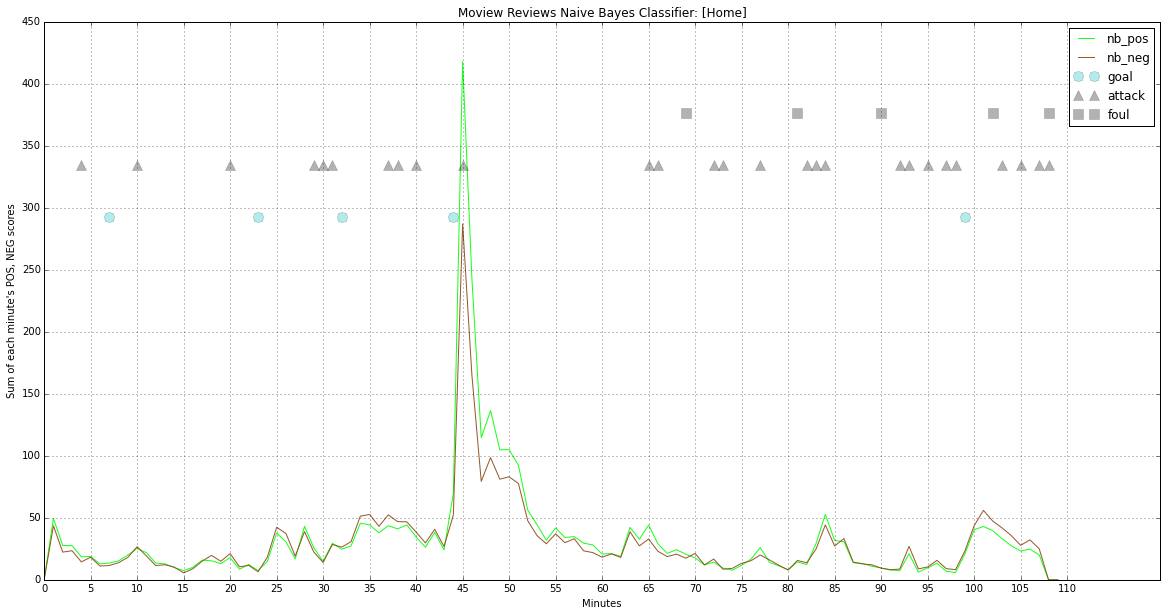

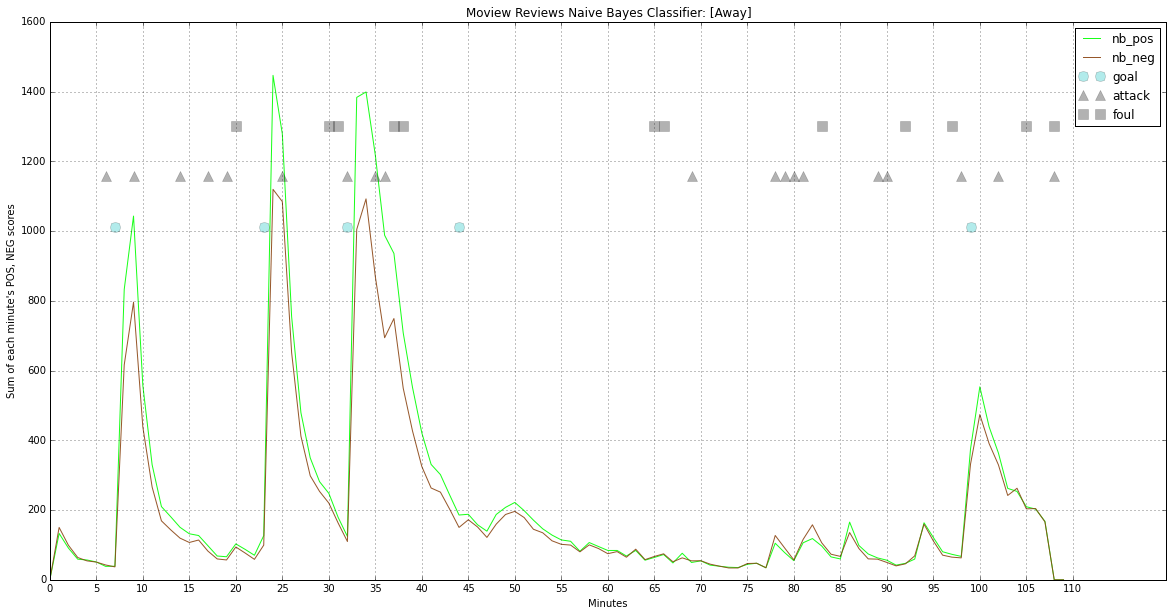

In [24]:
my_plot.PlotLineChart(
    my_list_list=[nb_pos_list_home, nb_neg_list_home],
    labels=['nb_pos', 'nb_neg'],
    colors=['lime', 'saddlebrown'],
    title="Moview Reviews Naive Bayes Classifier: [Home]",
    xlabel="Minutes",
    ylabel="Sum of each minute's POS, NEG scores",
    x_interval=5,
    grid=True,
    points=[goals_dic, attacks_dic_home, fouls_dic_home],
)

my_plot.PlotLineChart(
    my_list_list=[nb_pos_list_away, nb_neg_list_away],
    labels=['nb_pos', 'nb_neg'],
    colors=['lime', 'saddlebrown'],
    title="Moview Reviews Naive Bayes Classifier: [Away]",
    xlabel="Minutes",
    ylabel="Sum of each minute's POS, NEG scores",
    x_interval=5,
    grid=True,
    points=[goals_dic, attacks_dic_away, fouls_dic_away],
)